# LangChain과 RAG란 무엇일까?

### 학습목표: 
>  ~~LangChain과 RAG 대해 이해하고, 실무 활용 가능한 챗봇을 구축해본다!  DS폐쇄망 이슈~~ 
>
>  LangChain과 RAG에 대해 이해한다.

### RAG(Retrieval Augmented Generation) 란
- 검색-증강 생성
- LLM이 외부 지식 베이스를 참조하여 최적화된 응답을 생성하는 기술입니다.
- RAG  = vector DB + LLM 
<br>

### LangChain이란

- LLM을 사용하여 애플리케이션을 개발하기 위한 프레임워크입니다.
- LLM애플리케이션 라이프사이클의 모든 단계를 단순화합니다.
- LCEL형태로 커스텀이 쉽다.
- https://www.langchain.com/langchain
<br>

### RAG가 왜 필요한가 (chatGPT 도 한계가 있다.)
- LLM 의 지식은 **고정적**입니다.
- **할루시네이션**이 발생할수 있다.
- 용어 혼동으로 인해 답변이 정확하지 않은 경우가 있다.


    > chat GPT 사용 -> 패키지 여행  
    >
    > RAG를 활용한 GPT 사용 -> 자유 여행

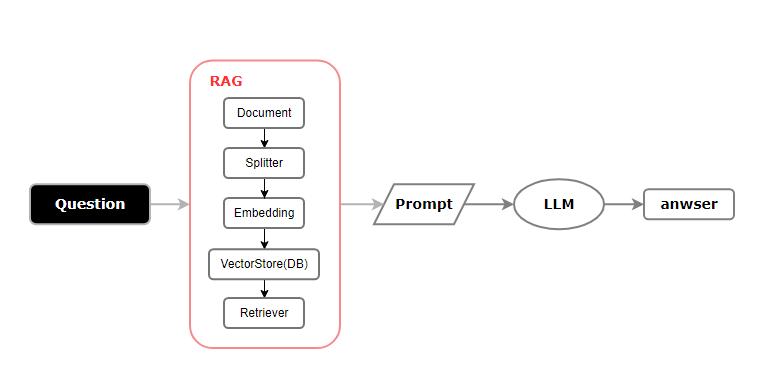
<br>

LLM 성능 극대화를 위한 기법(OpenAI)
https://www.youtube.com/watch?v=ahnGLM-RC1Y

- LLM을 사용하는 기법에 의한 성능향상
- 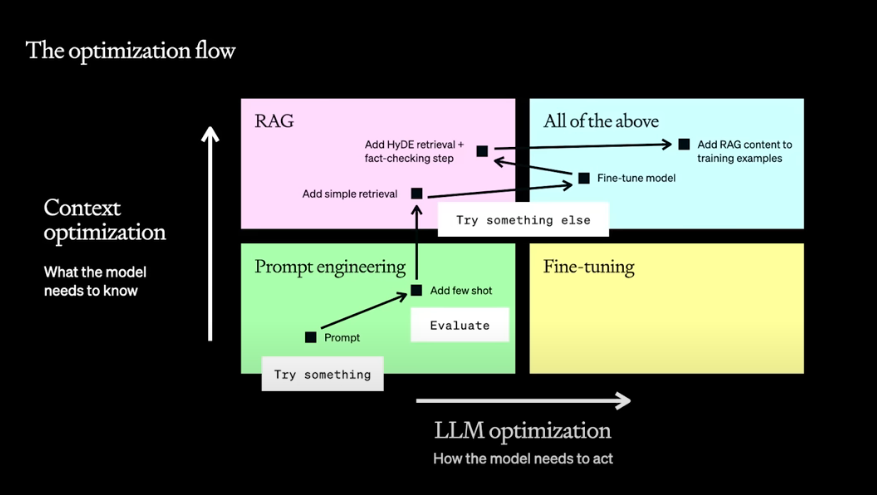
- 기본-초급-중급-고급 RAG에 따른 성능향상
- 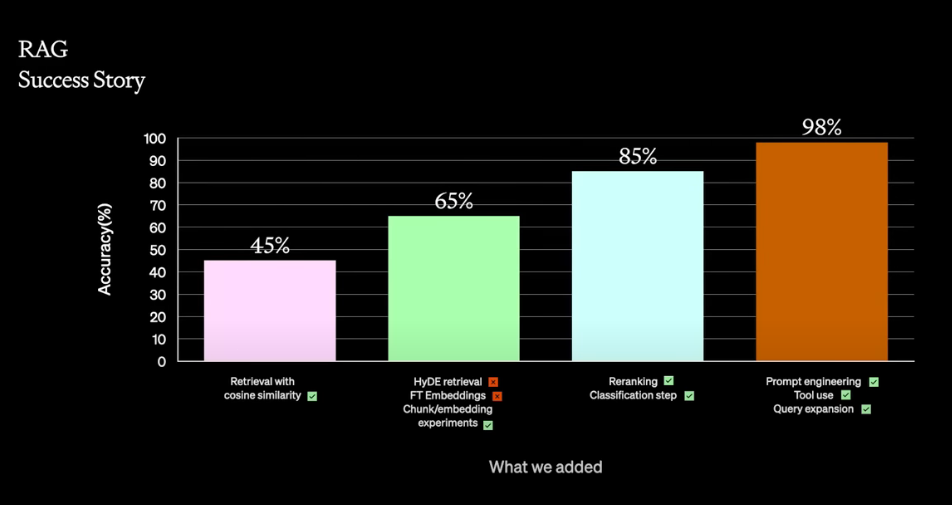

<br>

### LangChain 의 구조
#### (Loaders - Text Splitter - Text Embedding - VectorStore - Retriever)
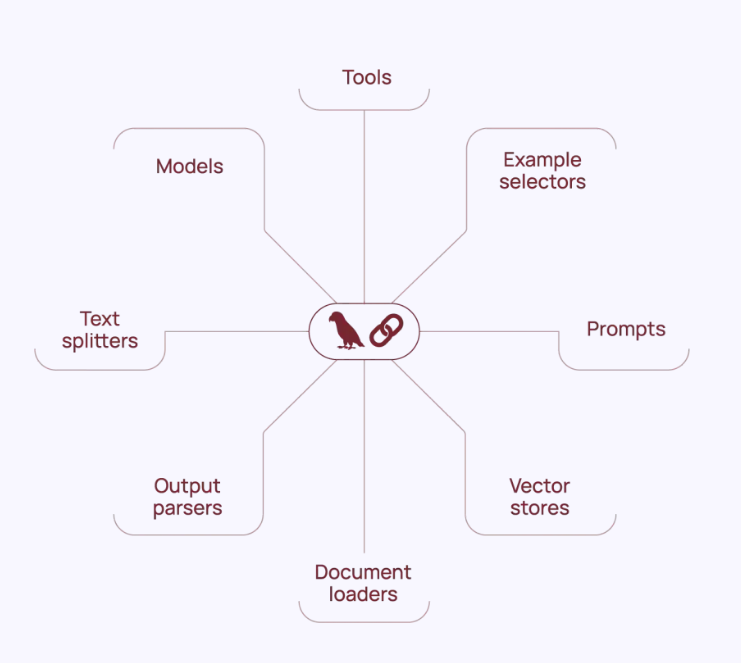

<br>


## 랭체인(LangChain)의 구성요소

- LLM
- Prompts
- chains
- indexes
	- Doc Loader 
	- Text Splitter 
	- Embedding 
	- Vector DB
- memory
- agents

## 랭체인(LangChain)으로 할 수 있는것

- Chatbots: 대화형 AI 챗봇을 구축
- Summarization:  뉴스, 연구 논문, 리포트 등의 주요 내용을 추출하여 간결한 요약본을 생성
- Question Answering: 문서나 데이터베이스에서 특정 질문에 대한 답변을 생성
- Data Augmentation: 기존 데이터를 다양화하거나 새로운 데이터 세트를 생성 등을 통해 데이터 세트를 보강
- AI Agents: 특정 업무를 자동화하거나, 사용자의 명령에 따라 다양한 작업을 수행하는 에이전트를 구축

### 예시: PDF 챗봇 구축

1. Document Loader 
	- PyMuPDFLoader를 활용해서 문서 가져오기

2. Text Splitter 
	- PDF 문서를 여러 문서로 분할
	- 적절한 chunk size와 overlap 파라미터로 TextSplitter 초기화
	- TextSplitter를 사용하여 로드된 문서를 작은 텍스트 조각들로 분할

3. Embed to Vectorstore 
	- 문서 조각을 수치화(임베딩)해서 Vectorstore에 저장
	- 임베딩 모델을 초기화 (chatGPT, llama, Huggingface ... )
	- 각 텍스트 조각에 대해:
		- 텍스트 조각을 임베딩 모델을 사용하여 임베딩(벡터화)으로 변환
		- 변환된 임베딩을 해당 텍스트 조각과 함께 Vectorstore(FAISS, Chroma ...)에 저장

4. VectorStore Retriever 
	- 질문과 연관성이 높은 문서 추출
	- Vectorstore를 사용하여 retriever 초기화
	- 입력: 사용자의 질문 또는 쿼리
	- retriever를 사용하여 질문과 가장 관련성이 높은 텍스트 조각들을 검색
	- 추가 처리를 위해 검색된 연관 텍스트 조각들을 저장

5. QA Chain 
	- Prompt1: 원래 질문과 검색된 연관 텍스트 조각들을 결합하여 프롬프트 생성
	- 생성된 Prompt1을 LLM에 전달하여 초기답변 얻기
	- Prompt2: 초기답변을 필요에 따라 추가 컨텍스트와 함께 LLM에 다시 전달하여 응답을 정제
	- 출력: 최종적으로 처리된 답변

In [1]:
pip install -qU langchain langchain-community pymupdf faiss-cpu openai


Note: you may need to restart the kernel to use updated packages.


In [28]:
# API KEY를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API KEY 정보로드
load_dotenv()


True

## 한국어 파인튜닝된 ollama 3.1 모델 설치하기

#### OpenAI api 를 쓰지 못하는 상황에서 사용

>https://huggingface.co/Saxo/Linkbricks-Horizon-AI-Korean-llama-3.1-sft-dpo-8B/blob/main/ggml-model-q5_k_m.gguf

Modelfile:
```python

FROM ggml-model-q5_k_m.gguf

TEMPLATE """{{- if .System }}
<s>{{ .System }}</s>
{{- end }}
<s>Human:
{{ .Prompt }}</s>
<s>Assistant:
"""

SYSTEM """A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions."""

PARAMETER temperature 0
PARAMETER num_predict 3000
PARAMETER num_ctx 4096
PARAMETER stop <s>
PARAMETER stop </s>

```

설치:
>ollama create llama3.1_ko -f Modelfile

In [29]:
# 단계 1: 문서 로드(Load Documents)  https://spri.kr/posts?code=AI-Brief
from langchain_community.document_loaders import PyMuPDFLoader
pdf_loader  = PyMuPDFLoader("./data/SPRi AI Brief_8월호_산업동향.pdf")
docs = pdf_loader.load()
docs
# for doc in docs:
#     print(doc.page_content)

[Document(metadata={'source': './data/SPRi AI Brief_8월호_산업동향.pdf', 'file_path': './data/SPRi AI Brief_8월호_산업동향.pdf', 'page': 0, 'total_pages': 23, 'format': 'PDF 1.4', 'title': '', 'author': 'dj', 'subject': '', 'keywords': '', 'creator': 'Hwp 2018 10.0.0.13947', 'producer': 'Hancom PDF 1.3.0.547', 'creationDate': "D:20240812101011+09'00'", 'modDate': "D:20240812101011+09'00'", 'trapped': ''}, page_content='2024년 8월호\n'),
 Document(metadata={'source': './data/SPRi AI Brief_8월호_산업동향.pdf', 'file_path': './data/SPRi AI Brief_8월호_산업동향.pdf', 'page': 1, 'total_pages': 23, 'format': 'PDF 1.4', 'title': '', 'author': 'dj', 'subject': '', 'keywords': '', 'creator': 'Hwp 2018 10.0.0.13947', 'producer': 'Hancom PDF 1.3.0.547', 'creationDate': "D:20240812101011+09'00'", 'modDate': "D:20240812101011+09'00'", 'trapped': ''}, page_content='2024년 8월호\nⅠ. 인공지능 산업 동향 브리프\n 1. 정책/법제 \n   ▹ 국제통화기금(IMF), 세계 AI 준비 현황지도 공개································································ 1\n   ▹ OECD, AI 분야의 데

In [72]:
# 단계 2: 문서 분할(Split Documents)  
# ChunkViz.com
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
split_docs = text_splitter.split_documents(docs[3:6])
split_docs

[Document(metadata={'source': './data/SPRi AI Brief_8월호_산업동향.pdf', 'file_path': './data/SPRi AI Brief_8월호_산업동향.pdf', 'page': 3, 'total_pages': 23, 'format': 'PDF 1.4', 'title': '', 'author': 'dj', 'subject': '', 'keywords': '', 'creator': 'Hwp 2018 10.0.0.13947', 'producer': 'Hancom PDF 1.3.0.547', 'creationDate': "D:20240812101011+09'00'", 'modDate': "D:20240812101011+09'00'", 'trapped': ''}, page_content='1. 정책/법제  \n2. 기업/산업 \n3. 기술/연구 \n 4. 인력/교육\n1\n국제통화기금(IMF), 세계 AI 준비 현황지도 공개\nn IMF가 전 세계 174개국을 대상으로 △디지털 인프라 △인적 자본과 노동시장 정책 △혁신과 \n경제 통합 △규제 4개 영역의 AI 준비 상태를 조사한 ‘AI 준비 지수 현황지도’를 공개\nn IMF는 선진국은 평균 AI 준비 지수가 0.68이었으나 저소득국은 0.32에 불과하다며, AI가 \n국가 간 불평등을 악화시킬 것을 우려하고 국가별 상황에 맞는 AI 정책 마련을 촉구\nKEY Contents\n£ 174개국 중 싱가포르가 AI 준비 지수 1위, 한국은 0.73으로 상위권\nn 국제통화기금(IMF)이 2024년 6월 25일 전 세계 174개국의 ‘AI 준비 지수 현황지도’를 공개\n∙AI 준비 지수는 △디지털 인프라 △인적 자본과 노동시장 정책 △혁신과 경제 통합 △규제 4개 영역에서의 \n준비 상태를 기준으로 평가\n∙국가별 준비 지수는 싱가포르가 0.80으로 가장 높았으며, 미국과 네덜란드가 0.77, 독일 0.75, 캐나다 \n0.71, 프랑스 0.7, 중국 0.64, 한국과 일본이 

In [58]:
# 단계 3: 임베딩(Embedding) 생성
# from langchain_openai import OpenAIEmbeddings
# embeddings_openai = OpenAIEmbeddings()

from langchain_community.embeddings import OllamaEmbeddings
embeddings_llama = OllamaEmbeddings(model="llama3.1_ko")

In [59]:
# 단계 4: 벡터스토어 생성(vector DB) 및 저장
from langchain_community.vectorstores import FAISS
# vectorstore = FAISS.from_documents(documents=split_docs, embedding=embeddings_openai)
vectorstore = FAISS.from_documents(documents=split_docs, embedding=embeddings_llama)
retriever = vectorstore.as_retriever()

In [75]:
# 단계 5: 프롬프트 생성(Create Prompt)
from langchain_core.prompts import PromptTemplate
prompt = PromptTemplate.from_template(
    """
    You are an assistant for question-answering tasks. 
    Answer in Korean.

    #Question: 
    {question} 
    #Context: 
    {context} 

    #Answer:
    
    Use the following pieces of retrieved context to answer the question. 
    If you don't know the answer, just say that you don't know. 
    """

)

In [76]:
# 단계 6: 언어모델(LLM) 생성  체인(Chain) 생성
# from langchain_openai import ChatOpenAI
# llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_community.chat_models import ChatOllama

llm = ChatOllama(model="llama3.1_ko")

chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [70]:
# 체인 실행(Run Chain)
# 문서에 대한 질의를 입력하고, 답변을 출력합니다.
question = "AI 준비 지수 1위는 어디야??"
response = chain.invoke(question)
response

'    AI 준비 지수 1위는 싱가포르입니다.'

In [79]:
# 체인 실행(Run Chain)
# 문서에 대한 질의를 입력하고, 답변을 출력합니다.
question = "LG AI연구원"
response = chain.invoke(question)
response

"    I don't have enough information in the provided context to answer your question about LG AI연구원. Could you please provide more details or clarify what you are looking for? I'll do my best to help."

https://github.com/open-webui/open-webui

### 지금 시작해도 늦지 않았다.
https://www.samsungsds.com/kr/insights/index.html?moreCnt=0&backTypeId=&category=&reqArtId=1282288

준비하며 배운점 어려웠던점
- 배운점: AI 트랜드가 굉장히 빠르게 바뀐다.
- 어려웠던점: DS 폐쇄망에서는 자유도가 매우 낮다. ㅜㅜ
